In [1]:
#EXP
#threshholde= 0.35
#weight = 0.4
#Duration = 5
#all fold
#39 resnest 50 nocall
# 224 400

In [2]:
!nvidia-smi

Wed Jun  2 04:12:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
try:
    import resnest
except ModuleNotFoundError:
    !pip install -q "../input/resnest50-fast-package/resnest-0.0.6b20200701/resnest"

In [4]:
import numpy as np
import librosa as lb
import librosa.display as lbd
import soundfile as sf
import pandas as pd
import cv2
from pathlib import Path
import re

import torch
from torch import nn
from  torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm

import time
from resnest.torch import resnest101
from resnest.torch import resnest50
#from resnest.torch import resnest50
import cv2

In [5]:
!pip install '../input/pytorchefficientnet/EfficientNet-PyTorch-master'

Processing /kaggle/input/pytorchefficientnet/EfficientNet-PyTorch-master
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.1-py3-none-any.whl size=16570 sha256=af6bb8d248492650f1526acee91f0583bfbb57f3713c43f2dc66b955057fcc5f
  Stored in directory: /root/.cache/pip/wheels/60/6e/67/37408498b7f8d996904785db949af7e0beaa74ecd6402be63f
Successfully built efficientnet-pytorch


In [6]:
from efficientnet_pytorch import EfficientNet
##import pretrainedmodels
import resnest.torch as resnest_torch

# Configs

In [7]:
NUM_CLASSES = 397
SR = 32_000
DURATION = 5
THRESH=0.35


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

TEST_AUDIO_ROOT = Path("../input/birdclef-2021/test_soundscapes")
SAMPLE_SUB_PATH = "../input/birdclef-2021/sample_submission.csv"
TARGET_PATH = None
    
if not len(list(TEST_AUDIO_ROOT.glob("*.ogg"))):
    TEST_AUDIO_ROOT = Path("../input/birdclef-2021/train_soundscapes")
    SAMPLE_SUB_PATH = None
    # SAMPLE_SUB_PATH = "../input/birdclef-2021/sample_submission.csv"
    TARGET_PATH = Path("../input/birdclef-2021/train_soundscape_labels.csv")

DEVICE: cuda


# Data

In [8]:
class MelSpecComputer:
    def __init__(self, sr, n_mels, fmin, fmax, **kwargs):
        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax
        kwargs["n_fft"] = kwargs.get("n_fft", self.sr//10)
        kwargs["hop_length"] = kwargs.get("hop_length", self.sr//(10*4))
        self.kwargs = kwargs

    def __call__(self, y):

        melspec = lb.feature.melspectrogram(
            y, sr=self.sr, n_mels=self.n_mels, fmin=self.fmin, fmax=self.fmax, **self.kwargs,
        )

        melspec = lb.power_to_db(melspec).astype(np.float32)
        
        return melspec

In [9]:
def mono_to_color(X, eps=1e-6, mean=None, std=None):
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

def crop_or_pad(y, length):
    if len(y) < length:
        y = np.concatenate([y, length - np.zeros(len(y))])
    elif len(y) > length:
        y = y[:length]
    return y

In [10]:
class BirdCLEFDataset(Dataset):
    def __init__(self, data, sr=SR, n_mels=128, fmin=0, fmax=None, duration=DURATION, step=None, res_type="kaiser_fast", resample=True):
        
        self.data = data
        
        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax or self.sr//2

        self.duration = duration
        self.audio_length = self.duration*self.sr
        self.step = step or self.audio_length
        
        self.res_type = res_type
        self.resample = resample

        self.mel_spec_computer = MelSpecComputer(sr=self.sr, n_mels=self.n_mels, fmin=self.fmin,
                                                 fmax=self.fmax)
    def __len__(self):
        return len(self.data)
    
    @staticmethod
    def normalize(image):
        image = image.astype("float32", copy=False) / 255.0
        image = np.stack([image, image, image])
        return image
    
    def audio_to_image(self, audio):
        melspec = self.mel_spec_computer(audio) 
        image = mono_to_color(melspec)
        image = cv2.resize(image, (int(400), 224))
        image = self.normalize(image)
        return image

    def read_file(self, filepath):
        audio, orig_sr = sf.read(filepath, dtype="float32")

        if self.resample and orig_sr != self.sr:
            audio = lb.resample(audio, orig_sr, self.sr, res_type=self.res_type)
          
        audios = []
        for i in range(self.audio_length, len(audio) + self.step, self.step):
            start = max(0, i - self.audio_length)
            end = start + self.audio_length
            audios.append(audio[start:end])
            
        if len(audios[-1]) < self.audio_length:
            audios = audios[:-1]
            
        images = [self.audio_to_image(audio) for audio in audios]
        images = np.stack(images)
        
        return images
    
        
    def __getitem__(self, idx):
        return self.read_file(self.data.loc[idx, "filepath"])

In [11]:
data = pd.DataFrame(
     [(path.stem, *path.stem.split("_"), path) for path in Path(TEST_AUDIO_ROOT).glob("*.ogg")],
    columns = ["filename", "id", "site", "date", "filepath"]
)
print(data.shape)
data.head()

(20, 5)


,filename,id,site,date,filepath
0,20152_SSW_20170805,20152,SSW,20170805,../input/birdclef-2021/train_soundscapes/20152...
1,57610_COR_20190904,57610,COR,20190904,../input/birdclef-2021/train_soundscapes/57610...
2,7843_SSW_20170325,7843,SSW,20170325,../input/birdclef-2021/train_soundscapes/7843_...
3,42907_SSW_20170708,42907,SSW,20170708,../input/birdclef-2021/train_soundscapes/42907...
4,7019_COR_20190904,7019,COR,20190904,../input/birdclef-2021/train_soundscapes/7019_...


In [12]:
'''
df_train = pd.read_csv("../input/birdclef-2021/train_metadata.csv")
xx = df_train.iloc[0:1,:]
xx['primary_label'] = 'nocall'

df_train = pd.concat([df_train, df_train.iloc[0:1,:]])
df_train = df_train.reset_index(drop=True)

LABEL_IDS = {label: label_id for label_id,label in enumerate(sorted(df_train["primary_label"].unique()))}
INV_LABEL_IDS = {val: key for key,val in LABEL_IDS.items()}
df_train.tail()
'''

'\ndf_train = pd.read_csv("../input/birdclef-2021/train_metadata.csv")\nxx = df_train.iloc[0:1,:]\nxx[\'primary_label\'] = \'nocall\'\n\ndf_train = pd.concat([df_train, df_train.iloc[0:1,:]])\ndf_train = df_train.reset_index(drop=True)\n\nLABEL_IDS = {label: label_id for label_id,label in enumerate(sorted(df_train["primary_label"].unique()))}\nINV_LABEL_IDS = {val: key for key,val in LABEL_IDS.items()}\ndf_train.tail()\n'

In [13]:

df_train = pd.read_csv("../input/birdclef-2021/train_metadata.csv")

LABEL_IDS = {label: label_id for label_id,label in enumerate(sorted(df_train["primary_label"].unique()))}
INV_LABEL_IDS = {val: key for key,val in LABEL_IDS.items()}


# Inference

In [14]:
test_data = BirdCLEFDataset(data=data)
len(test_data), test_data[0].shape

(20, (120, 3, 224, 400))

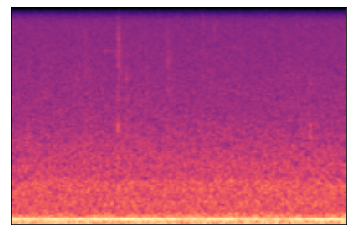

In [15]:
lbd.specshow(test_data[0][1][0])

In [16]:
def load_net(checkpoint_path, num_classes=NUM_CLASSES):
    #net = resnest50(pretrained=False)
    net = EfficientNet.from_name('efficientnet-b3')
    #net.fc = nn.Linear(net.fc.in_features, num_classes)
    nb_ft = net._fc.in_features
    net._fc = nn.Linear(nb_ft,num_classes)
    dummy_device = torch.device("cpu")
    d = torch.load(checkpoint_path, map_location=dummy_device)
    for key in list(d.keys()):
        d[key.replace("model.", "")] = d.pop(key)
    net.load_state_dict(d)
    net = net.to(DEVICE)
    net = net.eval()
    return net

def load_net_res(checkpoint_path, num_classes=NUM_CLASSES):
    net = resnest101(pretrained=False)
    ##net = EfficientNet.from_name('efficientnet-b4')
    net.fc = nn.Linear(net.fc.in_features, num_classes)
    ##nb_ft = net._fc.in_features
    ##net._fc = nn.Linear(nb_ft,num_classes)
    dummy_device = torch.device("cpu")
    d = torch.load(checkpoint_path, map_location=dummy_device)
    for key in list(d.keys()):
        d[key.replace("model.", "")] = d.pop(key)
    net.load_state_dict(d)
    net = net.to(DEVICE)
    net = net.eval()
    return net

def load_net_res50(checkpoint_path, num_classes=NUM_CLASSES):
    net = resnest50(pretrained=False)
    ##net = EfficientNet.from_name('efficientnet-b4')
    net.fc = nn.Linear(net.fc.in_features, num_classes)
    ##nb_ft = net._fc.in_features
    ##net._fc = nn.Linear(nb_ft,num_classes)
    dummy_device = torch.device("cpu")
    d = torch.load(checkpoint_path, map_location=dummy_device)
    for key in list(d.keys()):
        d[key.replace("model.", "")] = d.pop(key)
    net.load_state_dict(d)
    net = net.to(DEVICE)
    net = net.eval()
    return net

In [17]:

checkpoint_paths = [
    Path("../input/39-resnest50-nocall-new/39_ResNeSt50_nocall_new/birdclef_resnest50_fold0_epoch_25_f1_val_06708_20210531054439.pth"),
    Path("../input/39-resnest50-nocall-new/39_ResNeSt50_nocall_new/birdclef_resnest50_fold1_epoch_22_f1_val_06714_20210531082120.pth"),
    Path("../input/39-resnest50-nocall-new/39_ResNeSt50_nocall_new/birdclef_resnest50_fold2_epoch_26_f1_val_06670_20210531113710.pth"),
    Path("../input/39-resnest50-nocall-new/39_ResNeSt50_nocall_new/birdclef_resnest50_fold3_epoch_27_f1_val_06640_20210531060021.pth"),
    Path("../input/39-resnest50-nocall-new/39_ResNeSt50_nocall_new/birdclef_resnest50_fold4_epoch_22_f1_val_06661_20210531082529.pth"),
]


nets = [
        load_net_res50(checkpoint_path.as_posix()) for checkpoint_path in checkpoint_paths
]

'''
checkpoint_paths_res = [
    Path("../input/birdcall2-21resnest101-cutmix-prima/21_resnest101_cutmix_primarl/birdclef_resnest101_fold0_epoch_37_f1_val_07114_20210516184207.pth"),
    Path("../input/birdcall2-21resnest101-cutmix-prima/21_resnest101_cutmix_primarl/birdclef_resnest101_fold1_epoch_30_f1_val_07213_20210516202755.pth"),
    Path("../input/birdcall2-21resnest101-cutmix-prima/21_resnest101_cutmix_primarl/birdclef_resnest101_fold2_epoch_32_f1_val_07212_20210516224253.pth"),
    Path("../input/birdcall2-21resnest101-cutmix-prima/21_resnest101_cutmix_primarl/birdclef_resnest101_fold3_epoch_37_f1_val_07137_20210517010742.pth"),
    Path("../input/birdcall2-21resnest101-cutmix-prima/21_resnest101_cutmix_primarl/birdclef_resnest101_fold4_epoch_36_f1_val_07198_20210517031258.pth")
]

nets_res = [
        load_net_res(checkpoint_path.as_posix()) for checkpoint_path in checkpoint_paths_res
]


checkpoint_paths = [
    Path("../input/birdcall2-18resnest-urz-nocall/18_resnest_urz_nocall/birdclef_resnest50_fold0_epoch_28_f1_val_07136_20210515193629.pth"),
    Path("../input/birdcall2-18resnest-urz-nocall/18_resnest_urz_nocall/birdclef_resnest50_fold1_epoch_28_f1_val_07011_20210515203356.pth"),
    Path("../input/birdcall2-18resnest-urz-nocall/18_resnest_urz_nocall/birdclef_resnest50_fold2_epoch_29_f1_val_07069_20210515213320.pth"),
    Path("../input/birdcall2-18resnest-urz-nocall/18_resnest_urz_nocall/birdclef_resnest50_fold3_epoch_29_f1_val_07072_20210515223052.pth"),
    Path("../input/birdcall2-18resnest-urz-nocall/18_resnest_urz_nocall/birdclef_resnest50_fold4_epoch_29_f1_val_07104_20210515232822.pth"),
]

nets = [
        load_net_res50(checkpoint_path.as_posix()) for checkpoint_path in checkpoint_paths
]

checkpoint_paths_eff = [
    Path("../input/baircall2-efficientnetb3/23_efficientnet_primarly/birdclef_efficientnet-b3_fold0_epoch_29_f1_val_06729_20210518171628.pth"),
    Path("../input/baircall2-efficientnetb3/23_efficientnet_primarly/birdclef_efficientnet-b3_fold1_epoch_28_f1_val_06797_20210518184704.pth"),
    Path("../input/baircall2-efficientnetb3/23_efficientnet_primarly/birdclef_efficientnet-b3_fold2_epoch_29_f1_val_06819_20210518202416.pth"),
    Path("../input/baircall2-efficientnetb3/23_efficientnet_primarly/birdclef_efficientnet-b3_fold3_epoch_29_f1_val_06726_20210518215812.pth"),
    Path("../input/baircall2-efficientnetb3/23_efficientnet_primarly/birdclef_efficientnet-b3_fold4_epoch_29_f1_val_06723_20210518233154.pth")
]

nets_eff = [
        load_net(checkpoint_path.as_posix()) for checkpoint_path in checkpoint_paths_eff
]
'''

'\ncheckpoint_paths_res = [\n    Path("../input/birdcall2-21resnest101-cutmix-prima/21_resnest101_cutmix_primarl/birdclef_resnest101_fold0_epoch_37_f1_val_07114_20210516184207.pth"),\n    Path("../input/birdcall2-21resnest101-cutmix-prima/21_resnest101_cutmix_primarl/birdclef_resnest101_fold1_epoch_30_f1_val_07213_20210516202755.pth"),\n    Path("../input/birdcall2-21resnest101-cutmix-prima/21_resnest101_cutmix_primarl/birdclef_resnest101_fold2_epoch_32_f1_val_07212_20210516224253.pth"),\n    Path("../input/birdcall2-21resnest101-cutmix-prima/21_resnest101_cutmix_primarl/birdclef_resnest101_fold3_epoch_37_f1_val_07137_20210517010742.pth"),\n    Path("../input/birdcall2-21resnest101-cutmix-prima/21_resnest101_cutmix_primarl/birdclef_resnest101_fold4_epoch_36_f1_val_07198_20210517031258.pth")\n]\n\nnets_res = [\n        load_net_res(checkpoint_path.as_posix()) for checkpoint_path in checkpoint_paths_res\n]\n\n\ncheckpoint_paths = [\n    Path("../input/birdcall2-18resnest-urz-nocall/18_re

In [18]:
#print(len(nets))
#print(len(nets_res))

In [19]:
@torch.no_grad()
def get_thresh_preds(out, thresh=None):
    thresh = thresh or THRESH
    o = (-out).argsort(1)
    npreds = (out > thresh).sum(1)
    preds = []
    for oo, npred in zip(o, npreds):
        preds.append(oo[:npred].cpu().numpy().tolist())
    return preds

In [20]:
'''
def get_bird_names(preds):
    bird_names = []
    for pred in preds:
        if not pred:
            bird_names.append("-")
        else:
            bird_names.append(" ".join([INV_LABEL_IDS[bird_id] for bird_id in pred]))
    return bird_names
'''

def get_bird_names(preds):
    bird_names = []
    for pred in preds:
        if not pred:
            bird_names.append("nocall")
        else:
            bird_names.append(" ".join([INV_LABEL_IDS[bird_id] for bird_id in pred]))
    return bird_names

In [21]:
def predict(nets, test_data, names=True):
    preds = []
    with torch.no_grad():
        for idx in  tqdm(list(range(len(test_data)))):
            xb = torch.from_numpy(test_data[idx]).to(DEVICE)
            pred = 0.
            for net in nets:
                o = net(xb)
                o = torch.sigmoid(o)

                pred += o

            pred /= len(nets)
            
            if names:
                pred = get_bird_names(get_thresh_preds(pred))

            preds.append(pred)
    return preds

In [22]:
pred_probas = predict(nets, test_data, names=False)
#pred_probas_res = predict(nets_res, test_data, names=False)
#pred_probas_eff = predict(nets_eff, test_data, names=False)
#print(len(pred_probas))
#print(len(pred_probas_res))

  0%|          | 0/20 [00:00<?, ?it/s]

In [23]:
#pred_probas_res[0].max()#shape

In [24]:
'''
weight1 = 0.6
#weight2 = 0.4
#pred_probas_all = pred_probas

pred_probas_all = []

for i in range(len(pred_probas_res)):
    pred_probas_all.append(pred_probas[i] * weight1 + 
                           pred_probas_res[i] * weight2 + 
                           pred_probas_eff[i] * (1-weight1-weight2))

for i in range(len(pred_probas_res)):
    pred_probas_all.append(pred_probas[i] * weight1 + 
                           pred_probas_res[i] * (1-weight1))
'''

'\nweight1 = 0.6\n#weight2 = 0.4\n#pred_probas_all = pred_probas\n\npred_probas_all = []\n\nfor i in range(len(pred_probas_res)):\n    pred_probas_all.append(pred_probas[i] * weight1 + \n                           pred_probas_res[i] * weight2 + \n                           pred_probas_eff[i] * (1-weight1-weight2))\n\nfor i in range(len(pred_probas_res)):\n    pred_probas_all.append(pred_probas[i] * weight1 + \n                           pred_probas_res[i] * (1-weight1))\n'

In [25]:
#pred_probas_all

In [26]:

preds = [get_bird_names(get_thresh_preds(pred, thresh=THRESH)) for pred in pred_probas]
#preds[:2]

In [27]:
def preds_as_df(data, preds):
    sub = {
        "row_id": [],
        "birds": [],
    }
    
    for row, pred in zip(data.itertuples(False), preds):
        row_id = [f"{row.id}_{row.site}_{5*i}" for i in range(1, len(pred)+1)]
        sub["birds"] += pred
        sub["row_id"] += row_id
        
    sub = pd.DataFrame(sub)
    
    if SAMPLE_SUB_PATH:
        sample_sub = pd.read_csv(SAMPLE_SUB_PATH, usecols=["row_id"])
        sub = sample_sub.merge(sub, on="row_id", how="left")
        sub["birds"] = sub["birds"].fillna("nocall")
    return sub

In [28]:
sub = preds_as_df(data, preds)
print(sub.shape)
sub.head(50)

(2400, 2)


,row_id,birds
0,20152_SSW_5,nocall
1,20152_SSW_10,nocall
2,20152_SSW_15,nocall
3,20152_SSW_20,nocall
4,20152_SSW_25,nocall
5,20152_SSW_30,nocall
6,20152_SSW_35,nocall
7,20152_SSW_40,nocall
8,20152_SSW_45,nocall
9,20152_SSW_50,nocall


In [29]:
sub.to_csv("submission.csv", index=False)

# Small validation

In [30]:
def get_metrics(s_true, s_pred):
    s_true = set(s_true.split())
    s_pred = set(s_pred.split())
    n, n_true, n_pred = len(s_true.intersection(s_pred)), len(s_true), len(s_pred)
    
    prec = n/n_pred
    rec = n/n_true
    f1 = 2*prec*rec/(prec + rec) if prec + rec else 0
    
    return {"f1": f1, "prec": prec, "rec": rec, "n_true": n_true, "n_pred": n_pred, "n": n}

In [31]:
if TARGET_PATH:
    sub_target = pd.read_csv(TARGET_PATH)
    sub_target = sub_target.merge(sub, how="left", on="row_id")
    
    print(sub_target["birds_x"].notnull().sum(), sub_target["birds_x"].notnull().sum())
    assert sub_target["birds_x"].notnull().all()
    assert sub_target["birds_y"].notnull().all()
    
    df_metrics = pd.DataFrame([get_metrics(s_true, s_pred) for s_true, s_pred in zip(sub_target.birds_x, sub_target.birds_y)])
    
    print(df_metrics.mean())

2400 2400
f1        0.692153
prec      0.706250
rec       0.687063
n_true    1.130000
n_pred    1.012083
n         0.712917
dtype: float64


In [32]:
##### sub_target[sub_target.birds_y != "nocall"]
sub_target[sub_target.birds_y != "-"]

,row_id,site,audio_id,seconds,birds_x,birds_y
0,7019_COR_5,COR,7019,5,nocall,nocall
1,7019_COR_10,COR,7019,10,nocall,nocall
2,7019_COR_15,COR,7019,15,nocall,nocall
3,7019_COR_20,COR,7019,20,nocall,nocall
4,7019_COR_25,COR,7019,25,nocall,bucmot2
...,...,...,...,...,...,...
2395,54955_SSW_580,SSW,54955,580,nocall,nocall
2396,54955_SSW_585,SSW,54955,585,grycat,nocall
2397,54955_SSW_590,SSW,54955,590,grycat,nocall
2398,54955_SSW_595,SSW,54955,595,nocall,nocall


In [33]:
sub_target['flag_nocall'] = (sub_target['birds_x'] == sub_target['birds_y'])
sub_target['flag_nocall'] = sub_target['flag_nocall'].apply(lambda x: 1 if x == True else 0)
xx = sub_target[sub_target.birds_x == "nocall"]
yy = sub_target[sub_target.birds_x != "nocall"]
rate = xx['flag_nocall'].sum()/len(xx)
bad_rate = len(yy[yy['birds_y']=='nocall'])/len(yy)
print('nocallを当てた割合 : ', rate)
print('誤ってnocallと推定した割合 : ', bad_rate)

nocallを当てた割合 :  0.9221713538260301
誤ってnocallと推定した割合 :  0.563719862227325


In [34]:

yy[yy['birds_y']=='nocall']

,row_id,site,audio_id,seconds,birds_x,birds_y,flag_nocall
240,11254_COR_5,COR,11254,5,rubwre1,nocall,0
268,11254_COR_145,COR,11254,145,obnthr1,nocall,0
269,11254_COR_150,COR,11254,150,obnthr1,nocall,0
293,11254_COR_270,COR,11254,270,brnjay,nocall,0
360,18003_COR_5,COR,18003,5,rucwar,nocall,0
...,...,...,...,...,...,...,...
2391,54955_SSW_560,SSW,54955,560,grycat,nocall,0
2393,54955_SSW_570,SSW,54955,570,grycat,nocall,0
2394,54955_SSW_575,SSW,54955,575,chswar,nocall,0
2396,54955_SSW_585,SSW,54955,585,grycat,nocall,0


In [35]:
sub_target[sub_target.birds_x != "nocall"]

,row_id,site,audio_id,seconds,birds_x,birds_y,flag_nocall
240,11254_COR_5,COR,11254,5,rubwre1,nocall,0
242,11254_COR_15,COR,11254,15,rubwre1,wbwwre1,0
244,11254_COR_25,COR,11254,25,rubwre1,rubwre1,1
267,11254_COR_140,COR,11254,140,obnthr1,obnthr1,1
268,11254_COR_145,COR,11254,145,obnthr1,nocall,0
...,...,...,...,...,...,...,...
2391,54955_SSW_560,SSW,54955,560,grycat,nocall,0
2393,54955_SSW_570,SSW,54955,570,grycat,nocall,0
2394,54955_SSW_575,SSW,54955,575,chswar,nocall,0
2396,54955_SSW_585,SSW,54955,585,grycat,nocall,0


In [36]:
(pred_probas[0])

tensor([[0.0070, 0.0072, 0.0170,  ..., 0.0107, 0.0034, 0.0027],
        [0.0066, 0.0078, 0.0167,  ..., 0.0120, 0.0030, 0.0029],
        [0.0074, 0.0058, 0.0156,  ..., 0.0141, 0.0035, 0.0031],
        ...,
        [0.0058, 0.0046, 0.0083,  ..., 0.0072, 0.0025, 0.0032],
        [0.0062, 0.0051, 0.0092,  ..., 0.0081, 0.0028, 0.0028],
        [0.0062, 0.0057, 0.0099,  ..., 0.0090, 0.0023, 0.0035]],
       device='cuda:0')